In [ ]:
import os
import glob
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd

# Audio processing
import librosa
import librosa.display

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle, class_weight

# Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    Conv2D,
    MaxPooling2D,
    GlobalAveragePooling2D,
)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

## Loading Dataset

Considering only more than 3 sec files and
labelling the files as Normal or Abnormal

TODO: Add artifacts (i.e. noises without heartbeat data) and ask the user to try again

In [2]:
# Load and label dataset
dataset = []
for folder in ["./set_a/**/*.wav", "./set_b/**/*.wav"]:
    for filename in glob.iglob(folder, recursive=True):
        if os.path.isfile(filename):
            # get the parent folder as label source
            label_folder = os.path.basename(os.path.dirname(filename)).lower()

            # skip unwanted labels
            if any(x in label_folder for x in ["unlabelled", "artifact"]):
                continue

            # classify label
            if "normal" in label_folder:
                label = "normal"
            else:
                label = "abnormal"

            try:
                duration = librosa.get_duration(filename=filename)
            except Exception as e:
                print(f"Error reading {filename}: {e}")
                continue

            if duration >= 3:
                slice_size = 3
                iterations = int((duration - slice_size) / (slice_size - 1)) + 1
                initial_offset = (duration - ((iterations * (slice_size - 1)) + 1)) / 2
                for i in range(iterations):
                    offset = initial_offset + i * (slice_size - 1)
                    dataset.append(
                        {
                            "filename": filename,
                            "label": label,
                            "offset": offset,
                        }
                    )

# convert to DataFrame
dataset = pd.DataFrame(dataset)
dataset = shuffle(dataset, random_state=42)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1281 entries, 1241 to 1126
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   filename  1281 non-null   object 
 1   label     1281 non-null   object 
 2   offset    1281 non-null   float64
dtypes: float64(1), object(2)
memory usage: 40.0+ KB


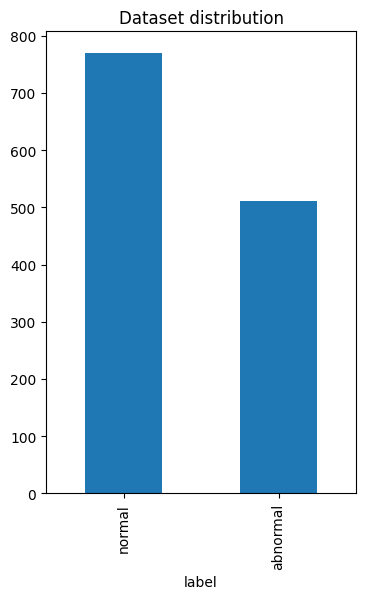

In [3]:
# Plot dataset distribution
plt.figure(figsize=(4, 6))
dataset.label.value_counts().plot(kind="bar", title="Dataset distribution")
plt.show()

## Split dataset in train and test
80-20 Ratio

In [4]:
# Split into train and test (80-20)
train, test = train_test_split(dataset, test_size=0.2, random_state=42)
print(f"Train: {len(train)}")
print(f"Test: {len(test)}")

Train: 1024
Test: 257


## Visualising the data and features

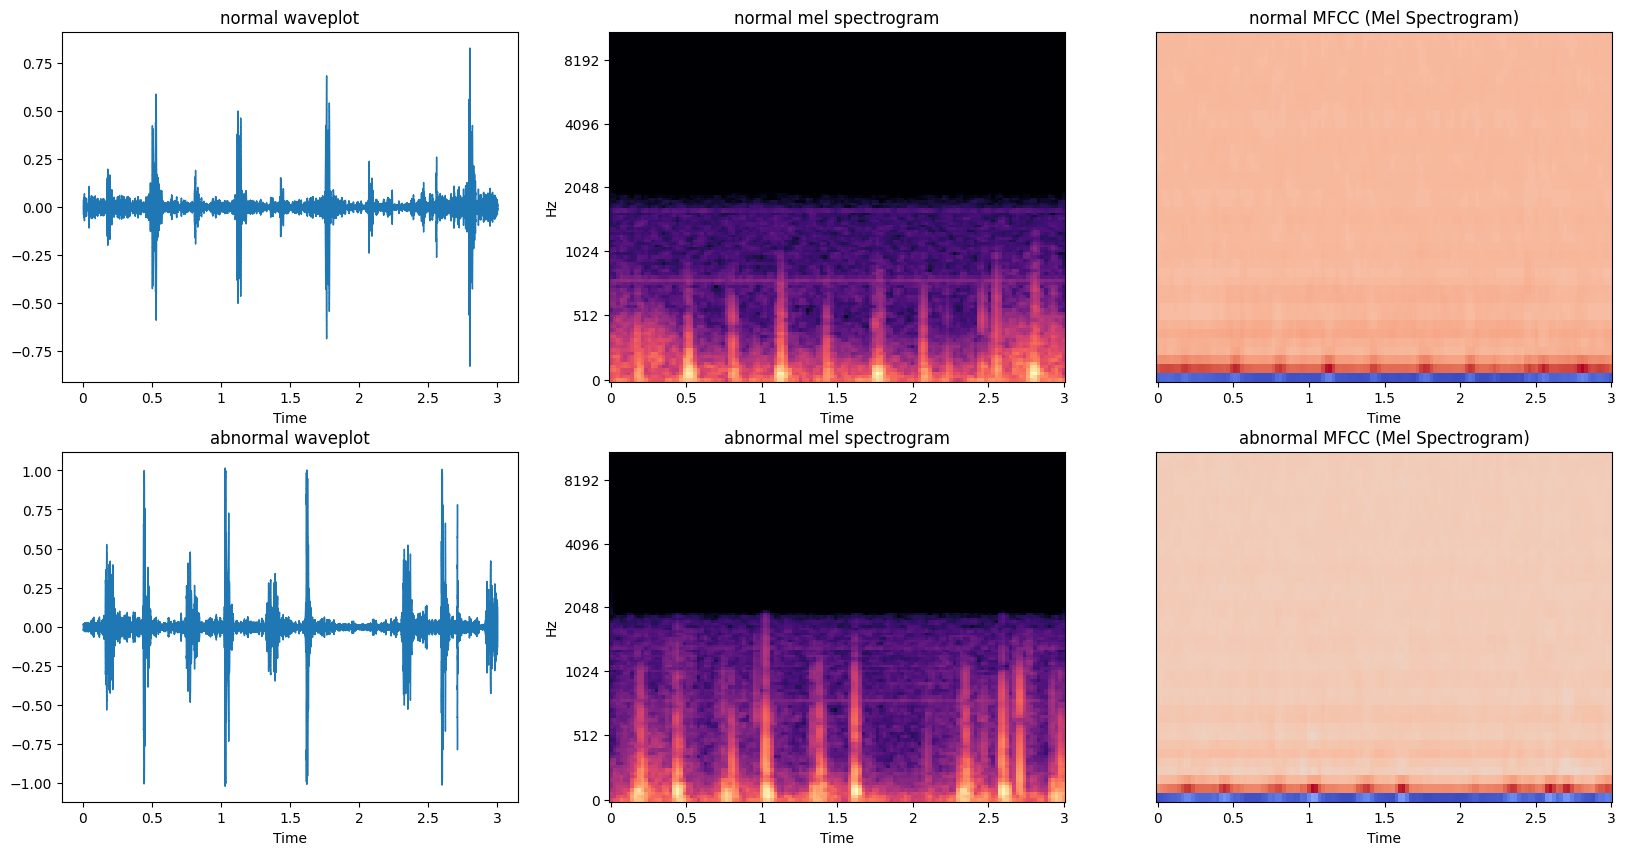

In [6]:
# Visualize waveplot, spectrogram and MFCC
plt.figure(figsize=(20, 10))
idx = 0
for label in dataset.label.unique():
    y, sr = librosa.load(dataset[dataset.label == label].filename.iloc[33], duration=3)
    idx += 1
    plt.subplot(2, 3, idx)
    plt.title(f"{label} waveplot")
    librosa.display.waveshow(y=y, sr=sr)

    idx += 1
    plt.subplot(2, 3, idx)
    S = librosa.feature.melspectrogram(
        y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=128
    )
    S_DB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_DB, sr=sr, hop_length=512, x_axis="time", y_axis="mel")
    plt.title(f"{label} mel spectrogram")

    idx += 1
    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=40)
    plt.subplot(2, 3, idx)
    librosa.display.specshow(mfccs, x_axis="time")
    plt.title(f"{label} MFCC (Mel Spectrogram)")
plt.show()

## Extracting features

In [7]:
# Extract features
def extract_features(audio_path, offset):
    y, sr = librosa.load(audio_path, offset=offset, duration=3)
    S = librosa.feature.melspectrogram(
        y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=128
    )
    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=40)
    return mfccs

In [8]:
x_train = [
    extract_features(train.filename.iloc[i], train.offset.iloc[i])
    for i in tqdm(range(len(train)))
]
x_test = [
    extract_features(test.filename.iloc[i], test.offset.iloc[i])
    for i in tqdm(range(len(test)))
]

x_train = np.asarray(x_train)
x_test = np.asarray(x_test)

100%|██████████| 257/257 [00:01<00:00, 145.55it/s]


In [15]:
# Encode labels
encoder = LabelEncoder()
encoder.fit(train.label)
y_train = encoder.transform(train.label)
y_test = encoder.transform(test.label)

# Compute class weights and convert to dict
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights_array))


## Input Shapes

In [16]:
# Reshape and one-hot encode labels
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

## Building Model

In [17]:
# Build CNN model
model = Sequential()
model.add(
    Conv2D(
        16,
        kernel_size=2,
        activation="relu",
        input_shape=(x_train.shape[1], x_train.shape[2], 1),
    )
)
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(32, kernel_size=2, activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(64, kernel_size=2, activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(128, kernel_size=2, activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))

model.add(GlobalAveragePooling2D())
model.add(Dense(len(encoder.classes_), activation="softmax"))
model.summary()

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 39, 129, 16)    │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 19, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 19, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 18, 63, 32)     │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 9, 31, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 9, 31, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 30, 64)      │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 4, 15, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 4, 15, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 3, 14, 128)     │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 1, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,570 (170.20 KB)

 Trainable params: 43,570 (170.20 KB)

 Non-trainable params: 0 (0.00 B)

## Compiling Model

In [18]:
# Compiling Model
model.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=0.001),
    metrics=["accuracy"],
)

## Fitting Model

In [19]:
# Train model
history = model.fit(
    x_train,
    y_train,
    batch_size=128,
    epochs=300,
    validation_data=(x_test, y_test),
    class_weight=class_weights,
    shuffle=True,
)

Epoch 1/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.4693 - loss: 11.6021 - val_accuracy: 0.6148 - val_loss: 0.6150
Epoch 2/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.5462 - loss: 5.0987 - val_accuracy: 0.4202 - val_loss: 2.7507
Epoch 3/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.5157 - loss: 3.5171 - val_accuracy: 0.6693 - val_loss: 0.5032
Epoch 4/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.5251 - loss: 2.3724 - val_accuracy: 0.5992 - val_loss: 0.5543
Epoch 5/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5445 - loss: 1.9101 - val_accuracy: 0.6342 - val_loss: 0.5047
Epoch 6/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5359 - loss: 1.4752 - val_accuracy: 0.6420 - val_loss: 0.5240
Epoch 7/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5806 - loss: 1.2177 - val_accuracy: 0.6265 - val_loss: 0.5190
Epoch 8/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5682 - loss: 1.0444 - val_accuracy: 0.6537 - val_loss

## Evaluating model

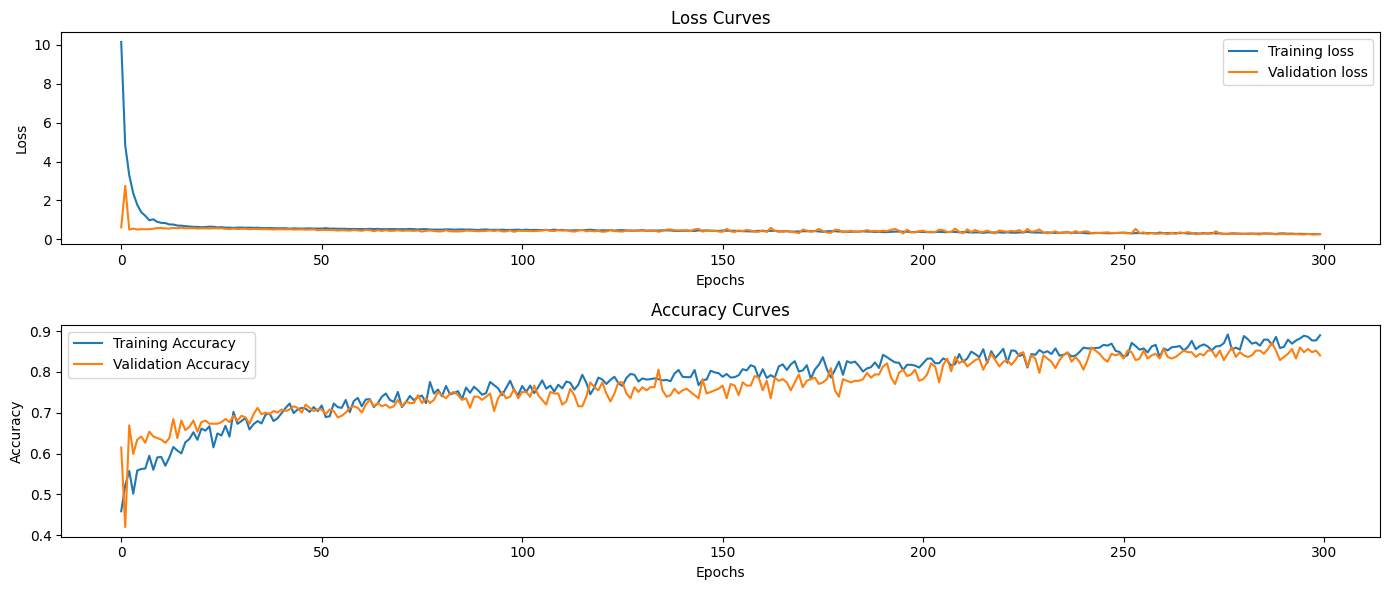

In [20]:
# Plot loss and accuracy curves
plt.figure(figsize=[14, 6])
plt.subplot(211)
plt.plot(history.history["loss"], label="Training loss")
plt.plot(history.history["val_loss"], label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()

plt.subplot(212)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Curves")
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
# Evaluate model
scores = model.evaluate(x_test, y_test, verbose=1)
print("Test loss:", scores[0])
print("Test accuracy:", scores[1])

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8338 - loss: 0.3345 
Test loss: 0.3134862780570984
Test accuracy: 0.8404669165611267


In [22]:
# Predict and show classification report
predictions = model.predict(x_test, verbose=1)
y_true = [encoder.classes_[np.argmax(y)] for y in y_test]
y_pred = [encoder.classes_[np.argmax(pred)] for pred in predictions]
print(classification_report(y_true, y_pred))

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
              precision    recall  f1-score   support

    abnormal       0.80      0.82      0.81       108
      normal       0.87      0.85      0.86       149

    accuracy                           0.84       257
   macro avg       0.84      0.84      0.84       257
weighted avg       0.84      0.84      0.84       257



### Save Model and Weights

In [ ]:
# Save model
model.save("model/heartbeat_classifier.keras")

### Classifying a heart beat

In [ ]:
from tensorflow.keras.models import load_model
import numpy as np

# Load model
model = load_model("model/heartbeat_classifier.keras")

# File to be classified
classify_file = "my_heartbeat.wav"

# Extract features and reshape
x_test = [extract_features(classify_file, 0.5)]
x_test = np.asarray(x_test)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

# Predict
pred = model.predict(x_test, verbose=1)

# Get predicted class
pred_class = np.argmax(pred, axis=1)

# Output
if pred_class[0] == 1:
    print("Normal heartbeat")
    print("Confidence:", pred[0][1])
else:
    print("Abnormal heartbeat")
    print("Confidence:", pred[0][0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Normal heartbeat
Confidence: 0.9594909


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))
